In [1]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
#from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [2]:
#  setting up device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [3]:
import os
import cv2
from natsort import natsorted

class Data():

    def __init__(self):
        pass

    def get_images(images_path):
    # speichert Bilder als numpy array

        array_images = []
        train_or_test_folder = os.listdir(images_path)

        for folder in natsorted(train_or_test_folder):
            single_folder = os.path.join(images_path, folder)

            for file in os.listdir(single_folder):
                filepath = os.path.join(single_folder, file)

                if filepath.lower().endswith(('.jpeg', '.jpg')):
                    image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                    array_images.append(image)

        images = np.array(array_images)
        
        return images
    
    def get_label(images_path):
    # speichert Lables als numpy array

        array_label = []
        for folder in natsorted(os.listdir(images_path)):
            label = int(folder)

            for file in os.listdir(os.path.join(images_path, folder)):
                array_label.append(label)
        labels = np.array(array_label)
            
        return labels
    
images = Data.get_images("../../02_data_crop/train")
labels = Data.get_label("../../02_data_crop/train") # train images

X_eval = Data.get_images("../../02_data_crop/test")
y_eval = Data.get_label("../../02_data_crop/test")  # Evaluierungs Bilder

In [4]:
print(labels)

[ 1  1  1 ... 26 26 26]


In [5]:
images, X_eval = images / 255.0, X_eval / 255.0

one hot encoding der Label

In [6]:
import keras
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
labels = keras.utils.to_categorical(labels, num_classes=27)
y_eval = keras.utils.to_categorical(y_eval, num_classes=27)

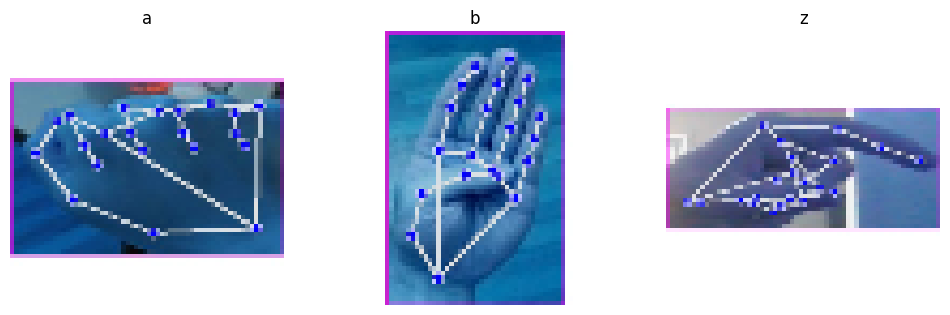

Label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1.]


In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Zeige die Bilder in den einzelnen Subplots
axs[0].imshow(images[0])
axs[0].axis('off')
axs[0].set_title('a')

axs[1].imshow(images[518])
axs[1].axis('off')
axs[1].set_title('b')

axs[2].imshow(images[10300])
axs[2].axis('off')
axs[2].set_title('z')

plt.show()

print(f"Label: {labels[0]}")
print(f"Label: {labels[518]}")
print(f"Label: {labels[10300]}")

dummy Klasse am Anfang

In [8]:
import numpy as np

label_to_count = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

matching_rows = np.all(labels == label_to_count, axis=1)

count = np.sum(matching_rows)

print(f"Anzahl der Einträge für das Label {label_to_count}: {count}")

Anzahl der Einträge für das Label [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]: 0


Aufteilung in Train und Testdaten

In [9]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# stratify = von jeder Klasse Daten

n = len(uniq_labels)
train_n = len(X_train) 
test_n = len(X_test)   
eval_n = len(X_eval)


tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Testbilder', test_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Testbilder            2074
Evaluierungsbilder    1448


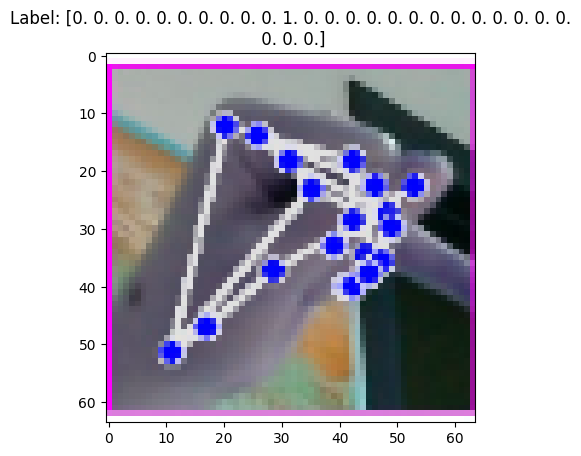

Bilder sind geshuffelt


In [10]:
# Anzeigen des Bildes
plt.imshow(X_train[0])
plt.title(f"Label: {y_train[0]}")
plt.show()
print('Bilder sind geshuffelt')

Erstellen des PyTorch Datasets

In [11]:
import torch
from torch.utils.data import Dataset

class PyTorchDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Erstellen des CustomDataset
training_dataset = PyTorchDataset(images=X_train, labels=y_train, transform=transforms.Compose([transforms.ToTensor()]))
                                                                                 #transforms.Normalize(mean=mean, std=std)]))
test_dataset = PyTorchDataset(images=X_test, labels=y_test, transform=transforms.Compose([transforms.ToTensor()]))
                                                                                 #transforms.Normalize(mean=mean, std=std)]))
eval_dataset = PyTorchDataset(images=X_eval, labels=y_eval, transform=transforms.Compose([transforms.ToTensor()]))
                                                                                 #transforms.Normalize(mean=mean, std=std)]))

In [12]:
num_training = len(training_dataset)
num_test = len(test_dataset) 
num_eval = len(eval_dataset)   
image_train, label_train = training_dataset[1]
shape = image_train.shape
type = image_train.type

tab = [['Trainingsbilder: ', num_training],['Testbilder: ', num_test],['Evaluierungsbilder: ', num_eval],
       ['Shape: ', shape], ['Type: ', type]]

print(tabulate(tab, headers=["Kenngröße", "Wert"]))

Kenngröße            Wert
-------------------  -------------------------------------------------------------
Trainingsbilder:     8294
Testbilder:          2074
Evaluierungsbilder:  1448
Shape:               torch.Size([64, 64, 3])
Type:                <built-in method type of Tensor object at 0x000001C05E586CF0>


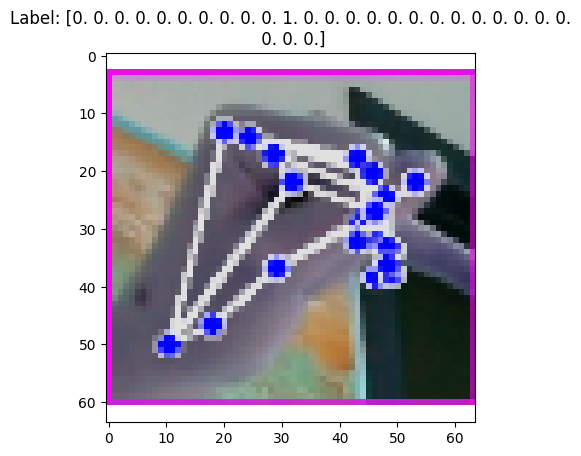

In [13]:
# Anzeigen des Bildes (muss vorher wieder denormalisiert werden)
denormalized_image = image_train * 255
plt.imshow(denormalized_image)
plt.title(f"Label: {label_train}")
plt.show()

## Model

In [14]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 8, 3, padding=1) # Kanäle, Ausbagekanäle, 3x3 Kernel
    self.batchnorm1 = nn.BatchNorm2d(8)

    self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
    self.batchnorm2 = nn.BatchNorm2d(8)
    self.pool2 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(8, 32, 3, padding=1)
    self.batchnorm3 = nn.BatchNorm2d(32)

    self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
    self.batchnorm4 = nn.BatchNorm2d(32)
    self.pool4 = nn.MaxPool2d(2)

    self.conv5 = nn.Conv2d(32, 128, 3, padding=1)
    self.batchnorm5 = nn.BatchNorm2d(128)
    
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.batchnorm6 = nn.BatchNorm2d(128)
    self.pool6 = nn.MaxPool2d(2)

    self.conv7 = nn.Conv2d(128, 27, 1)
    self.pool7 = nn.AvgPool2d(5)

  def forward(self, x):
    #-------------
    # INPUT
    #-------------
    x = x.view(-1, 3, 64, 64)   # Umwandlung des Tensors in das erwartete Format
    
    #-------------
    # LAYER 1
    #-------------
    output_1 = self.conv1(x)   # Faltung des Eingabebildes mit den Filtern von cnv1
    output_1 = F.relu(output_1) # Aktivierungsfunktion
    output_1 = self.batchnorm1(output_1)

    #-------------
    # LAYER 2
    #-------------
    output_2 = self.conv2(output_1)
    output_2 = F.relu(output_2)
    output_2 = self.pool2(output_2)
    output_2 = self.batchnorm2(output_2)

    #-------------
    # LAYER 3
    #-------------
    output_3 = self.conv3(output_2)
    output_3 = F.relu(output_3)
    output_3 = self.batchnorm3(output_3)

    #-------------
    # LAYER 4
    #-------------
    output_4 = self.conv4(output_3)
    output_4 = F.relu(output_4)
    output_4 = self.pool4(output_4)
    output_4 = self.batchnorm4(output_4)

    #-------------
    # LAYER 5
    #-------------
    output_5 = self.conv5(output_4)
    output_5 = F.relu(output_5)
    output_5 = self.batchnorm5(output_5)

    #-------------
    # LAYER 6
    #-------------
    output_6 = self.conv6(output_5)
    output_6 = F.relu(output_6)
    output_6 = self.pool6(output_6)
    output_6 = self.batchnorm6(output_6)

    #--------------
    # OUTPUT LAYER
    #--------------
    output_7 = self.conv7(output_6)
    output_7 = self.pool7(output_7)
    output_7 = output_7.view(-1, 27)
    print(output_7.shape)

    return F.softmax(output_7, dim=1)

In [15]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
class ConvolutionalNeuralNet():
  def __init__(self, network):
    self.network = network.to(device)
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  defining accuracy function
    def accuracy(network, dataloader):
      network.eval()
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        predictions = torch.argmax(network(images), dim=1)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      return round(total_correct/total_instances, 3)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)

    #  setting convnet to training mode
    self.network.train()

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      for images, labels in tqdm(train_loader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        self.optimizer.zero_grad()
        #  making predictions
        predictions = self.network(images)
        #  computing loss
        loss = loss_function(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        self.optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy = accuracy(self.network, train_loader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      self.network.eval()

      with torch.no_grad():
        for images, labels in tqdm(val_loader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = self.network(images)
          #  computing loss
          val_loss = loss_function(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy = accuracy(self.network, val_loader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

      train_losses = np.array(train_losses).mean()
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}\n')
      
    return log_dict

  def predict(self, x):
    return self.network(x)

In [18]:
#!jupyter nbextension enable --py widgetsnbextension


In [17]:
#  training model
model = ConvolutionalNeuralNet(ConvNet())

log_dict = model.train(nn.CrossEntropyLoss(), epochs=10, batch_size=64, 
                       training_set=training_dataset, validation_set=eval_dataset)

Epoch 1/10
training...


  0%|          | 0/130 [00:00<?, ?it/s]

torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([64, 27])
torch.Size([6

  0%|          | 0/130 [00:00<?, ?it/s]

torch.Size([64, 27])


RuntimeError: The size of tensor a (64) must match the size of tensor b (27) at non-singleton dimension 1

In [ ]:
class ConvolutionalNeuralNet_2():
  def __init__(self, network):
    self.network = network.to(device)
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'training_recall_per_epoch': [],
        'training_precision_per_epoch': [],
        'validation_accuracy_per_epoch': [],
        'validation_recall_per_epoch': [],
        'validation_precision_per_epoch': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  defining accuracy function
    def accuracy(network, dataloader):
      network.eval()
      
      all_predictions = []
      all_labels = []

      #  computing accuracy
      total_correct = 0
      total_instances = 0
      for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        all_labels.extend(labels)
        predictions = torch.argmax(network(images), dim=1)
        all_predictions.extend(predictions)
        correct_predictions = sum(predictions==labels).item()
        total_correct+=correct_predictions
        total_instances+=len(images)
      accuracy = round(total_correct/total_instances, 3)

      #  computing recall and precision
      true_positives = 0
      false_negatives = 0
      false_positives = 0
      for idx in range(len(all_predictions)):
        if all_predictions[idx].item()==1 and  all_labels[idx].item()==1:
          true_positives+=1
        elif all_predictions[idx].item()==0 and all_labels[idx].item()==1:
          false_negatives+=1
        elif all_predictions[idx].item()==1 and all_labels[idx].item()==0:
          false_positives+=1
      try:
        recall = round(true_positives/(true_positives + false_negatives), 3)
      except ZeroDivisionError:
        recall = 0.0
      try:
        precision = round(true_positives/(true_positives + false_positives), 3)
      except ZeroDivisionError:
        precision = 0.0
      return accuracy, recall, precision

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)

    #  setting convnet to training mode
    self.network.train()

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #  training
      print('training...')
      for images, labels in tqdm(train_loader):
        #  sending data to device
        images, labels = images.to(device), labels.to(device)
        #  resetting gradients
        self.optimizer.zero_grad()
        #  making predictions
        predictions = self.network(images)
        #  computing loss
        loss = loss_function(predictions, labels)
        log_dict['training_loss_per_batch'].append(loss.item())
        train_losses.append(loss.item())
        #  computing gradients
        loss.backward()
        #  updating weights
        self.optimizer.step()
      with torch.no_grad():
        print('deriving training accuracy...')
        #  computing training accuracy
        train_accuracy, train_recall, train_precision = accuracy(self.network, train_loader)
        log_dict['training_accuracy_per_epoch'].append(train_accuracy)
        log_dict['training_recall_per_epoch'].append(train_recall)
        log_dict['training_precision_per_epoch'].append(train_precision)

      #  validation
      print('validating...')
      val_losses = []

      #  setting convnet to evaluation mode
      self.network.eval()

      with torch.no_grad():
        for images, labels in tqdm(val_loader):
          #  sending data to device
          images, labels = images.to(device), labels.to(device)
          #  making predictions
          predictions = self.network(images)
          #  computing loss
          val_loss = loss_function(predictions, labels)
          log_dict['validation_loss_per_batch'].append(val_loss.item())
          val_losses.append(val_loss.item())
        #  computing accuracy
        print('deriving validation accuracy...')
        val_accuracy, val_recall, val_precision = accuracy(self.network, val_loader)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)
        log_dict['validation_recall_per_epoch'].append(val_recall)
        log_dict['validation_precision_per_epoch'].append(val_precision)

      train_losses = np.array(train_losses).mean()
      val_losses = np.array(val_losses).mean()

      print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+
      f'{train_accuracy}  training_recall: {train_recall}  training_precision: {train_precision} *~* validation_loss: {round(val_losses, 4)} '+  
      f'validation_accuracy: {val_accuracy}  validation_recall: {val_recall}  validation_precision: {val_precision}\n')
      
    return log_dict

  def predict(self, x):
    return self.network(x)

In [ ]:
#  training model
model = ConvolutionalNeuralNet_2(ConvNet())

weight = torch.tensor((0, 1.0))

log_dict = model.train(nn.CrossEntropyLoss(weight=weight), epochs=10, batch_size=64, 
                       training_set=training_data, validation_set=validation_data)

In [ ]:
#  training model
model = ConvolutionalNeuralNet_2(ConvNet())

weight = torch.tensor((0.15, 0.85))

log_dict = model.train(nn.CrossEntropyLoss(weight=weight), epochs=10, batch_size=64, 
                       training_set=training_data, validation_set=validation_data)

In [ ]:
""" 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 32, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(32)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(32, 128, 3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.pool6 = nn.MaxPool2d(2)

        # Ändere die Anzahl der Ausgabekanäle auf die Anzahl der Klassen
        self.conv7 = nn.Conv2d(128, 27, 1) 

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        print(x.shape)

        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = self.pool4(x)
        print(x.shape)

        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = F.relu(self.batchnorm6(self.conv6(x)))
        x = self.pool6(x)
        print(x.shape)

        x = F.avg_pool2d(F.relu(self.conv7(x)), kernel_size=x.size()[2:])

        return x.view(x.size(0), -1)
"""